In [1]:
#!pip install -r gen_ai/requirements.txt

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU found.")

GPU Name: NVIDIA GeForce RTX 3090


## Load embeddings from here



In [3]:
##################################################################################################################################################################

In [4]:
import pickle
from typing import List, Literal
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import copy
import json
from typing import List, Dict
import transformers
import string



from langchain.tools import BaseTool, Tool  # Para criar ferramentas personalizadas
#from langchain.agents import initialize_agent  # Para configurar o agente
#from langchain.chat_models import ChatOpenAI  # Para usar modelos de linguagem



thread_states = {}

# Definir o schema de estado
#class EmbeddingDict(TypedDict):
    #key1: str
    #key2: str
    #key3: str
    #key4: List[float]

class State(TypedDict):
    graph_state: str
    query: str
    embeddings_loaded: bool
    query_template: str
    query_embedding: List
    metadados: List
    resulting_context: List
    llm_response: str
    thread: str
    context_decision: str
    system_message: str
    # Adicione outros campos conforme necessário

# Variável global para armazenar embeddings na memória
embeddings_in_memory = None
# Load model and tokenizer
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"  # Replace if needed
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Configure BitsAndBytes for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="fp4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,  # Correct quantization parameter
    device_map="auto",
)

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
)

#embddings model
from sentence_transformers import SentenceTransformer
embeddings_model = SentenceTransformer("sentence-transformers/gtr-t5-large")



/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


## functions

In [5]:
# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_embeddings(state: State) -> Literal["load_embeddings_files", "create_query_embedding"]:
    if state["embeddings_loaded"] == True:
        print("will NOT load embeddings")
        return "create_query_embedding"
    else:
        print("laoding embeddings")
        return "load_embeddings_files"

# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_context(state: State) -> Literal["use_RAG", "plans_comparison_tool"]:
    print(state["context_decision"])
    if "plans_tool" in state["context_decision"] or "specific" in state["context_decision"]:
        return "plans_comparison_tool"   
    else:       
        return "use_RAG"
    
# Function: Decidir o próximo nó com base no histórico
def decide_next_node_history(state: State) -> Literal["bring_conversation_history", "create_system_message"]:    
    if 1==1:
        
        return "bring_conversation_history"
    else:
        
        return "create_system_message"

# Function: Decidir o próximo nó com base no estado atualizado
def decide_next_node_short(state: State) -> Literal["make_history_short", END]:
    if 1==1:
        return "make_history_short"
    else:
        return END

# Func: cria mensagem de sistema
def system_message_RAG(context_list) -> str:
    
    formatted_context = []
    for result in context_list:
        try:
            # Formatar os metadados seguidos pelo texto
            formatted_entry = (
                f"Document: {result['document_name']}\n"
                f"Page: {result['page_num']}\n"
                f"Text: {result['text']}\n"
                "----------------------\n"
                )
        except:
            formatted_entry = str(result)

        formatted_context.append(formatted_entry)    
    # Juntar todos os textos formatados em uma única string
    final_context = "\n".join(formatted_context)
    system_message_and_context = (
    "Check if the userer's quesiton can be answered by the content present in the context: "
    "If the answer is not in the context, say that you don't know. "
    "If the answer is in the context, just reply it based on context. "
   f"<context>{final_context}</context>"    
    )
    return system_message_and_context

# Func: cria mensagem de sistema
def system_message_plans(context) -> str:
    
    system_message_and_context = (
    "Check if the userr's quesiton can be answered by the content present bellow."
    "The context represents a table, a structured comparison of features across two subscription plans offered by Pixsee Planet."
    "It organizes information into rows, each representing a specific feature, and columns that correspond to the available plans."
    "The columns are labeled with the names of the features, and the rows contain the values for each feature in the respective plans."	
    "This format highlights the availability or functionality of each feature in a clear, side-by-side layout, making it easy to compare the offerings of each plan."
    "If the answer is not in the context, say that you don't know."
    "If the answer is in the context, just reply it based on context."
   f"<context>{context}</context>"    
    )
    return system_message_and_context



def load_data(file_path: str) -> List[Dict]:
    """
    Carrega os dados estruturados do arquivo JSON.
    """
    with open(file_path, 'r') as f:
        return json.load(f)

#from typing import List, Dict
#from langchain.tools import BaseTool



In [6]:
DESCRIPTION_FAQ_TOOL = """

"""

DESCRIPTION_PLANS_COMP_TOOL = """
Use it to answer questions about prices or cost of the plans, features available or not in each plan. 
This tool will provide access to a table is a structured comparison of features across two subscription plans offered by Pixsee Planet. 
It organizes information into rows, each representing a specific feature, and columns that correspond to the available plans. 
This format highlights the availability or functionality of each feature in a clear, side-by-side layout, making it easy to compare the offerings of each plan."""

DESCRIPTION_RAG = """
Use it to answer any other type of question.
"""



## Tools

In [7]:
from langchain.tools import BaseTool
import json

class PlansTool(BaseTool):
    name: str = "plans_tool"
    description: str = (
        "Use this tool to read a JSON file containing information about plan prices and features."
    )

    file_path: str = None  # The file path is now expected to be passed as a parameter.

    def _run(self, file_path: str):
        """
        Reads the JSON file specified by the file_path and returns its contents.
        """
        self.file_path = file_path  # Set the file path dynamically
        try:
            with open(self.file_path, "r", encoding="utf-8") as f:
                data = json.load(f)  # Load the JSON content
            return data
        except FileNotFoundError:
            return f"Error: File not found at {self.file_path}."
        except json.JSONDecodeError:
            return f"Error: Failed to decode JSON file at {self.file_path}."
        except Exception as e:
            return f"An unexpected error occurred: {e}"

    def _arun(self, file_path: str):
        """
        Asynchronous execution is not supported.
        """
        raise NotImplementedError("This tool does not support asynchronous execution.")


## Nodes

In [8]:
# Node: Receber a query
def use_RAG(state: State) -> State:
    print("---use_RAG---")    
    state["graph_state"] = "use_RAG"
    return state

# Node: Carregar embeddings do disco e atualizar o estado
def load_embeddings_files(state: State) -> State:
    print("---load_embeddings_files---")
    
    state["graph_state"] = "load_embeddings_files" 
    with open("/home/jovyan/gen_ai/chunks_with_embeddings.pkl", "rb") as f:
        chunks = pickle.load(f)
    # Atualizar o estado com os embeddings carregados
    state["embeddings_loaded"] = True
    #print("Estado atualizado:", state)
    import faiss
    import numpy as np
    
    # Extraia os embeddings e metadados
    embeddings = np.array([chunk['embedding'] for chunk in chunks]).astype('float32')
    metadados = [{'text': chunk['text'], 'page_num': chunk['page_num'], 'document_name': chunk['document_name']} for chunk in chunks]

    state["metadados"] = metadados

    #print(state)
    # Inicialize o índice FAISS
    dimension = embeddings.shape[1]  # Dimensão dos embeddings
    
    global faiss_index
    faiss_index = faiss.IndexFlatL2(dimension)  # Índice de similaridade (L2 - Euclidean Distance)
    
    # Adicione os embeddings ao índice FAISS (globall)
    faiss_index.add(embeddings)
    print(f"{faiss_index.ntotal} embeddings adicionados ao índice FAISS.")    
    return state

# Node: Criar a embeddings da query
def create_query_embedding(state: State) -> State:
    print("---create_query_embedding---")
    state["graph_state"] = "create_query_embedding"    
    # Gerar o embedding da consulta usando o modelo
    query_embedding = embeddings_model.encode(state["query"]).astype('float32')
    state["query_embedding"] = query_embedding
    return state


# Node: verifica similaridade entre embeddings
def verify_embeddings_similarity_on_FAISS(state: State) -> State:
    print("---verify_embeddings_similarity---")
    state["graph_state"] = "verify_embeddings_similarity_on_FAISS" 

    # Consultar o FAISS para encontrar os k embeddings mais próximos
    k = 3 # number of embeddings
    distances, indices = faiss_index.search(state["query_embedding"].reshape(1, -1), k)    

    metadados = state["metadados"]
    
    # Recuperar os textos correspondentes a partir dos metadados
    resulting_context = [metadados[idx] for idx in indices[0] if idx != -1]

    state["resulting_context"] = resulting_context 

    #delete unecessary content from state
    state["query_embedding"] = None
    #state["metadados"] = None   
    
    return state
        

# Node: Construir query_template
def build_prompt_template(state: State) -> State:
    print("---build_prompt_template---")
    state["graph_state"] = "build_prompt_template"    

    if state["thread"] in thread_states:
        # Recupera o conteúdo atual do "system" e combina com os novos resultados
        print(state)
        thread_system_content = thread_states[state["thread"]][0]["content"]
        if thread_system_content != state['resulting_context']:
            combined_list = thread_system_content + state['resulting_context']
        else:
            combined_list = thread_system_content

        unique_list = [dict(t) for t in {frozenset(d.items()) for d in combined_list}]
        
        # Atualiza apenas o conteúdo do "system"
        thread_states[state["thread"]][0]["content"] = unique_list
        
        # Adiciona a nova query como uma nova mensagem do usuário
        #thread_states[state["thread"]].append({"role": "user", "content": state["query"]}) 

        #create the query tenplate
        state["query_template"] = copy.deepcopy(thread_states[state["thread"]])

        #system_message_and_context = create_system_message(state["query_template"][0]["content"])

        state["query_template"][0]["content"] = copy.deepcopy(state["system_message"])

        print("QQQQQQQQQQQQTTTTTTTTTT")   
        print(state["query_template"])    

            
    else:
        #create initial prompt template         
        state["query_template"] = copy.deepcopy([{"role": "system", "content": state["system_message"]},
                        {"role": "user", "content": state["query"]}])        
  
    return state


# Node: Construir system message
def create_system_message(state: State) -> State:
    print("---create_system_message---")

    print("the graph state")
    print(state["graph_state"])
    
    if state["graph_state"] == "plans_comparison_tool":
        state["system_message"] = system_message_plans(state["resulting_context"])
        print("call tool function")

    else:
        print("call RAG function")
        state["system_message"] = system_message_RAG(state["resulting_context"]) 
    
    thread_states[state["thread"]] = [{"role": "system", "content": state["resulting_context"]}, {"role": "user", "content": state["query"]}] 
       
                 
    state["graph_state"] = "create_system_message"
    return state

# Node: Chamar o LLM
def llm_call(state: State) -> State:
    print("---llm_call---")    
    state["graph_state"] = "llm_call"

    # Preparar os inputs
    
    
    prompt = [{"role": "system", "content": state["query_template"]}, {"role": "user", "content": state["query"]}]
    
    outputs = pipeline(
    prompt,
    max_new_tokens=250,
)
    answer = outputs[0]["generated_text"][-1]   

    #update the threads with the llm-OUTput
    thread_states[state["thread"]].append({"role": "model", "content": answer})
    
    return state


def make_history_short(state: State) -> State:
    print("---make_history_short---")    
    state["graph_state"] = "make_history_short" 
    if not isinstance(state, dict):
        raise TypeError("O 'state' deve ser um dicionário.")
    state["query"] = None
    state["resulting_context"] = None
    # Limita o histórico a 2 interações + 1 mensagem system
    if len(state["query_template"]) > 12:  # 1 mensagem 'system' + 2 mensagens 
        system_message = [copy.deepcopy(thread_states[state["thread"]][0])]
        final_dialog = copy.deepcopy(thread_states[state["thread"]][-12:])
        system_message.extend(final_dialog)
        thread_states[state["thread"]] = system_message
        
    return state

def bring_conversation_history(state: State) -> State:
    state["graph_state"] = "bring_conversation_history" 
    return state


def context_decision_node(state):
    """
    Usa o LLM para decidir qual ferramenta utilizar com base na query.
    """
    query = state["query"]

    # Criar o prompt para o LLM
    system_message = f"""
    Bellow are the descriptions of the available tools:    
    1. plans_tool:
    {DESCRIPTION_PLANS_COMP_TOOL}
    2. use_RAG:
    {DESCRIPTION_RAG}
    Your role is to analyse the user's question and decide which tools is the best tool to answer the user's question.
    Answer in one word only.
    Example of Answer : use_RAG or plans_tool.
    """
    
    prompt = [{"role": "system", "content": system_message}, {"role": "user", "content": query}]
    
    outputs = pipeline(
    prompt,
    max_new_tokens=50,
)
    decision = outputs[0]["generated_text"][-1]      

    # Armazenar a decisão no estado
    state["context_decision"] = decision["content"]


    return state


def plans_comparison_tool(state):
    """
    Process the query using plans tool
    """
    state["graph_state"] = "plans_comparison_tool"
    url = "/home/jovyan/gen_ai/structured_subscription_data_with_categories.json"
    state["resulting_context"] = PlansTool()._run(url)
    return state




In [9]:
from IPython.display import Image, display

# Criar o grafo
builder = StateGraph(State)

# Adicionar todos os nodes
builder.add_node("context_decision_node", context_decision_node)
builder.add_node("use_RAG", use_RAG)
builder.add_node("plans_comparison_tool", plans_comparison_tool)
builder.add_node("load_embeddings_files", load_embeddings_files)
builder.add_node("create_query_embedding", create_query_embedding)
builder.add_node("verify_embeddings_similarity_on_FAISS", verify_embeddings_similarity_on_FAISS)
builder.add_node("bring_conversation_history", bring_conversation_history)
builder.add_node("create_system_message", create_system_message)
builder.add_node("build_prompt_template", build_prompt_template)
builder.add_node("llm_call", llm_call)
builder.add_node("make_history_short", make_history_short)

In [10]:
# Conectar START ao primeiro node
builder.add_edge(START, "context_decision_node")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "context_decision_node",
    decide_next_node_context  # Passar a função que decide o próximo node
)

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "use_RAG",
    decide_next_node_embeddings  # Passar a função que decide o próximo node
)

# Conectar os demais nodes
builder.add_edge("load_embeddings_files", "create_query_embedding")
builder.add_edge("create_query_embedding", "verify_embeddings_similarity_on_FAISS")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "verify_embeddings_similarity_on_FAISS",
    decide_next_node_history  # Passar a função que decide o próximo node
)

builder.add_edge("bring_conversation_history", "create_system_message")

builder.add_edge("create_system_message", "build_prompt_template") 

builder.add_edge("build_prompt_template", "llm_call")

# Configurar arestas condicionais para check_embeddings
builder.add_conditional_edges(
    "llm_call",
    decide_next_node_short  # Passar a função que decide o próximo node
)

builder.add_edge("make_history_short", END)

builder.add_edge("plans_comparison_tool", "create_system_message")



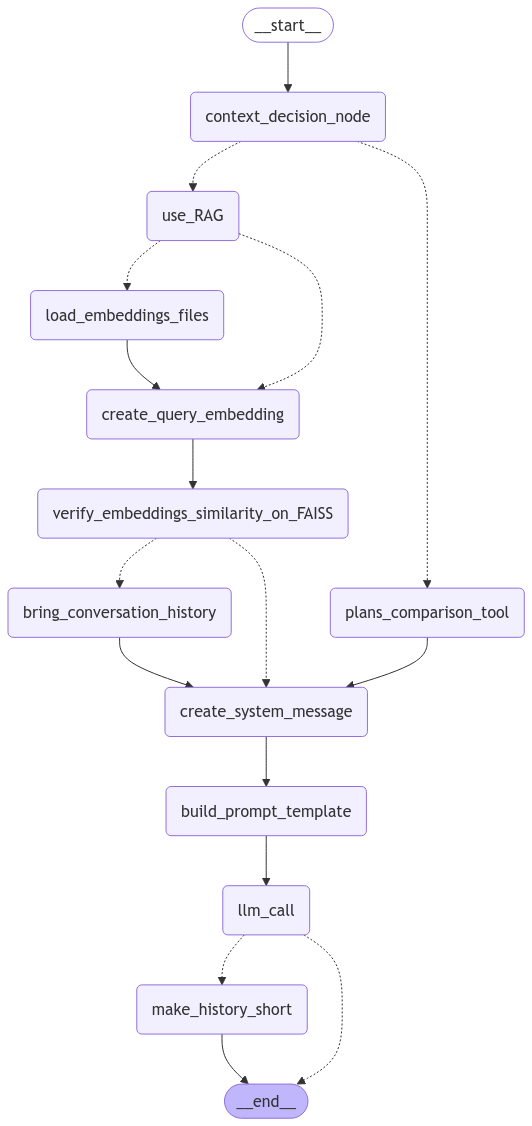

In [11]:
# Inicializa o MemorySaver e compila o gráfico
#checkpointer = MemorySaver()
# Compilar o grafo
graph = builder.compile()

#


# Visualizar o grafo (opcional)
display(Image(graph.get_graph().draw_mermaid_png()))


In [12]:
def call_graph(query, thread="1"):
    # Verificar se a variável `initial_state` está no escopo global
    if 'state' not in globals():
        global initial_state  # Declarar como global para criar ou reutilizar
        initial_state = {
            "graph_state": "START",  # Ponto de entrada do grafo
            "query": query,
            "embeddings": [],  # Inicialmente vazio
            "embeddings_loaded": False,
            "thread": thread,
        }
    
    else:
        initial_state = state
        initial_state["query"] = query
        
    # Executar o grafo
    result = graph.invoke(initial_state)
    
    # Verificar o resultado final
    return result



In [20]:
# Solicitar entrada do usuário
user_input = input("Enter your question or instruction: ")

# Passar o input do usuário para o call_graph
state = call_graph(user_input, thread="1")

# Exibir a resposta do LLM
#print(state["llm_response"])


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


use_RAG
---use_RAG---
laoding embeddings
---load_embeddings_files---
59 embeddings adicionados ao índice FAISS.
---create_query_embedding---
---verify_embeddings_similarity---
---create_system_message---
the graph state
bring_conversation_history
call RAG function
---build_prompt_template---
{'graph_state': 'build_prompt_template', 'query': 'how to clean the equipment?', 'embeddings_loaded': True, 'query_template': [{'role': 'system', 'content': "Check if the userr's quesiton can be answered by the content present bellow.The context represents a table, a structured comparison of features across two subscription plans offered by Pixsee Planet.It organizes information into rows, each representing a specific feature, and columns that correspond to the available plans.The columns are labeled with the names of the features, and the rows contain the values for each feature in the respective plans.This format highlights the availability or functionality of each feature in a clear, side-by-sid

In [14]:
#state = call_graph("How can I turn the equipment off?", thread="1")
#print(state["llm_response"])

In [15]:
#######################################################################

In [21]:
state

{'graph_state': 'make_history_short',
 'query': None,
 'embeddings_loaded': True,
 'query_template': [{'role': 'system',
   'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>Document: smart_baby_camera.pdf\nPage: 25\nText: water or beverages and other liquids. Improper use will void your warranty. - ● Before cleaning your product, please ensure power is turned off, and the power cord from the AC adapter is disconnected. Cleaning and maintenance (stand) - ● Please use a clean dry cloth for cleaning and wiping. Disclaimers - · This product manual is provided 'as-is' without warranties of any kind, either express or implied. To the maximum extent permitted by applicable law, we provide the document AS IS AND WITH\n----------------------\n\nDocument: smart_baby_camera.pdf\nPage: 25\nText: Cleaning and mainten

In [22]:
thread_states

{'1': [{'role': 'system',
   'content': [{'page_num': 21,
     'text': 'and all its functions before actually using the product to familiarize yourself with this product during actual use. - ● Do not cover this product or cables with towels and blankets. - ● When the product is in operation, it will dissipate normal heat produced to the surface of the product. Please do not leave the product on your knees or any part of your body for an extended period of time to avoid possible physical discomfort due to high temperature. - ● Please avoid placing this product near',
     'document_name': 'smart_baby_camera.pdf'},
    {'page_num': 25,
     'document_name': 'smart_baby_camera.pdf',
     'text': 'Cleaning and maintenance (camera) - ● Please use a clean dry cloth for cleaning and wiping. - ● Do not use strong solvents such as thinners, benzene-containing solvents or other chemical solvents next to or on this product. - ● This product only features splash-proof water protection. Please do n

In [23]:
state["query_template"]

[{'role': 'system',
  'content': "Check if the userer's quesiton can be answered by the content present in the context: If the answer is not in the context, say that you don't know. If the answer is in the context, just reply it based on context. <context>Document: smart_baby_camera.pdf\nPage: 25\nText: water or beverages and other liquids. Improper use will void your warranty. - ● Before cleaning your product, please ensure power is turned off, and the power cord from the AC adapter is disconnected. Cleaning and maintenance (stand) - ● Please use a clean dry cloth for cleaning and wiping. Disclaimers - · This product manual is provided 'as-is' without warranties of any kind, either express or implied. To the maximum extent permitted by applicable law, we provide the document AS IS AND WITH\n----------------------\n\nDocument: smart_baby_camera.pdf\nPage: 25\nText: Cleaning and maintenance (camera) - ● Please use a clean dry cloth for cleaning and wiping. - ● Do not use strong solvents